In [ ]:
#imports
import torch
import cv2
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt



In [ ]:
#Normal Cnn
class NormalConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),

            nn.Linear(256, 150),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(150,6)
        )

    def forward(self, x):
        x = self.clayer(x)
        return x



In [ ]:
class TreeCnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.branch1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1,1)),

            #nn.Flatten()
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1,1)),

            #nn.Flatten()
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, padding=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=7, padding=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1,1)),

            #nn.Flatten()
        )

        self.head = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(256*3, 300),
            #nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(300, 6)
            #nn.Linear(256,6)
        )
    def forward(self, x):
        x = self.stem(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)

        x = torch.cat([x1,x2,x3], dim=1)
        #x = x1+x2+x3

        x = self.head(x)
        return x

In [ ]:
def prepare_img(image):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std = [0.229, 0.224, 0.225])
  image = cv2.resize(image, (224,224))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype(np.float32)/255
  image = np.transpose(image, (2,0,1))
  image = torch.from_numpy(image)
  image = normalize(image)

  image = image.unsqueeze(0)

  return image

def check_img(model, image):
  with torch.no_grad():
    outputs = model(image)
  probs = torch.softmax(outputs,dim=1)
  #print(probs)
  conf, idx = torch.max(probs, dim=1)
  #print(idx)
  classes = ["Fresh Apple", "Fresh Banana", "Fresh Orange", "Rotten Apple", "Rotten Bannana", "Rotten Orange"]

  print(f"{classes[idx.item()]} with confidence of {conf.item()*100}%")

  confidences = probs.squeeze(0)
  confidences = confidences*100
  plt.bar(classes, confidences.numpy())
  plt.ylabel('Confidence')
  plt.xticks(rotation=45)
  plt.title("Confidence Bar Chart")
  print()

  plt.show()


In [ ]:

# loading normal_conv model
model1 = NormalConvModel()
state_dict = torch.load('/content/normal_conv_model.pth', map_location='cpu')
model1.load_state_dict(state_dict=state_dict)
model1.eval()


#loading TreeCnn Model
model2 = TreeCnn()
state_dict = torch.load('/content/TreeCnn_Model.pth', map_location='cpu')
model2.load_state_dict(state_dict=state_dict)
model2.eval()


TreeCnn(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (branch2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=

# Testing with photos

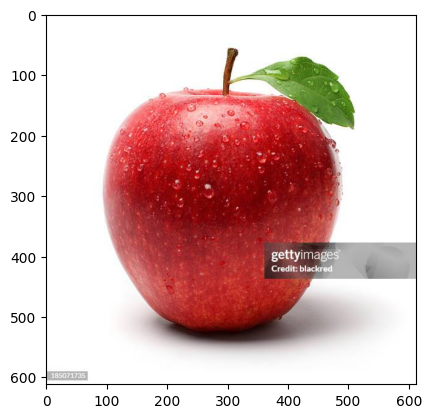

In [ ]:
#fresh-apple_with_white_bg.jpg

img = plt.imread('/content/apple_with_white_bg.jpg')
plt.imshow(img)

NameError: name 'model1' is not defined

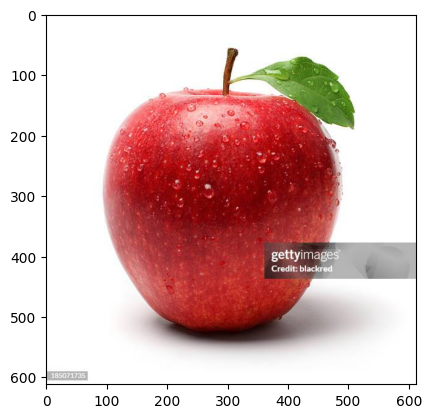

In [ ]:
img = cv2.imread('/content/apple_with_white_bg.jpg')
img = prepare_img(img)
check_img(model1, img)

Fresh Apple with confidence of 99.98747110366821%



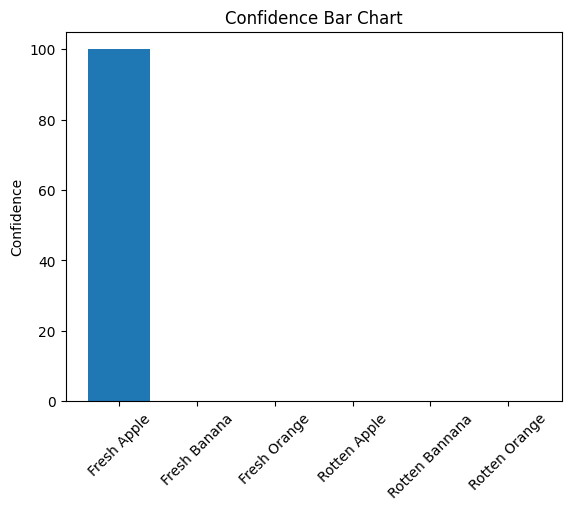

In [ ]:
img = cv2.imread("/content/apple_with_white_bg.jpg")
img = prepare_img(img)
check_img(model2, img)

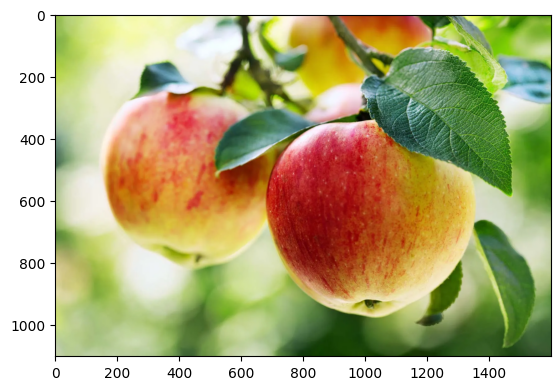

In [ ]:
#apples-on-a-tree-branch.webp
img = plt.imread('/content/apples-on-a-tree-branch.webp')
plt.imshow(img)

Fresh Banana with confidence of 90.96283316612244%



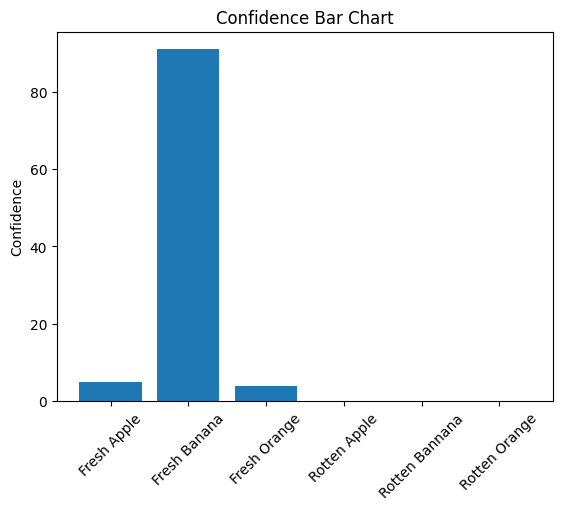

In [ ]:
img = cv2.imread('/content/apples-on-a-tree-branch.webp')
img = prepare_img(img)
check_img(model1, img)

Fresh Apple with confidence of 99.66484904289246%



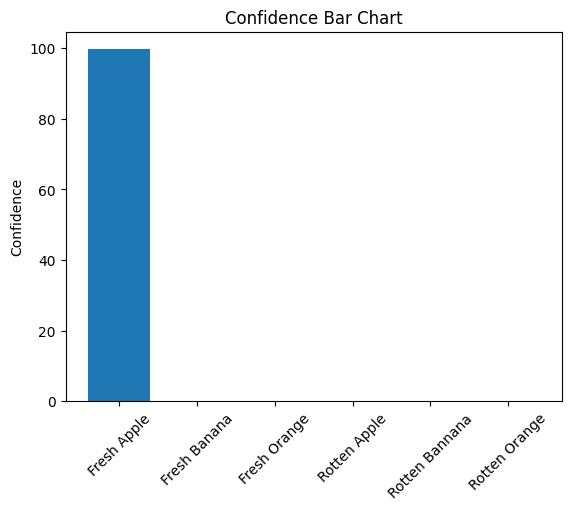

In [ ]:
img = cv2.imread("/content/apples-on-a-tree-branch.webp")
img = prepare_img(img)
check_img(model2, img)

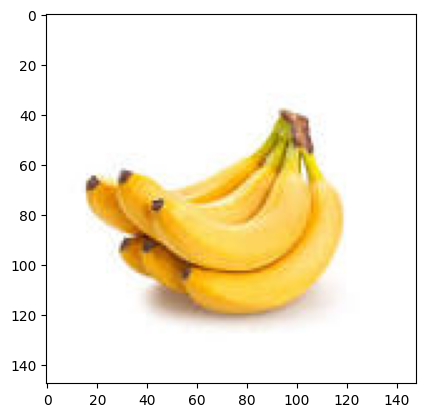

In [ ]:
#banana-with-white-bg.jpg
img = plt.imread('/content/banana-with-wh-bg.jpg')
plt.imshow(img)

Fresh Banana with confidence of 99.68372583389282%



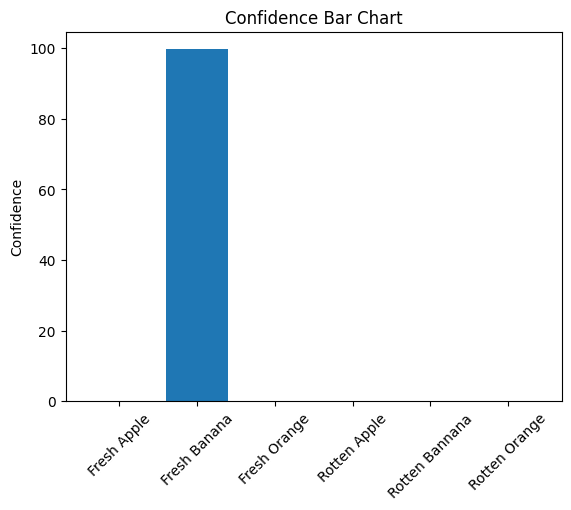

In [ ]:
img = cv2.imread('/content/banana-with-wh-bg.jpg')
img = prepare_img(img)
check_img(model1, img)

Fresh Banana with confidence of 99.90366697311401%



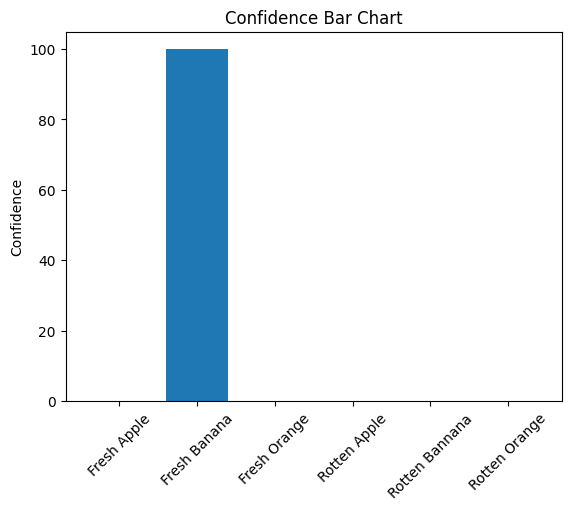

In [ ]:
img = cv2.imread("/content/banana-with-wh-bg.jpg")
img = prepare_img(img)
check_img(model2, img)

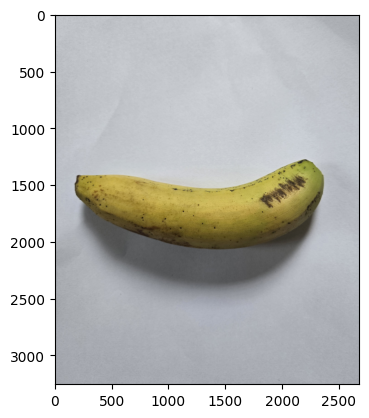

In [ ]:
#a partially rotten cliked_banana.jpg
img = plt.imread('/content/cliked_banana.jpg')
plt.imshow(img)

Rotten Bannana with confidence of 72.36958742141724%



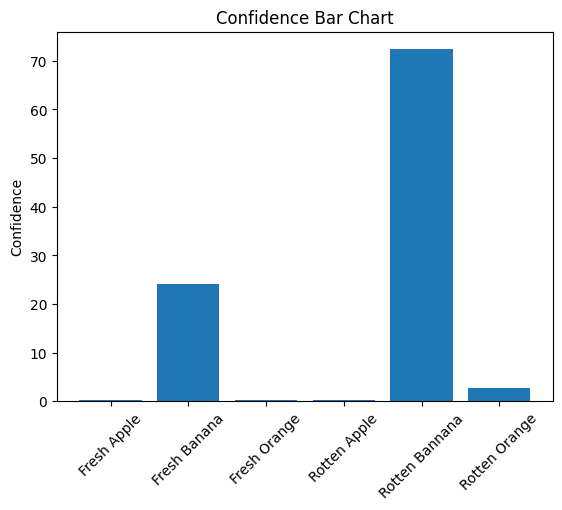

In [ ]:

img = cv2.imread('/content/cliked_banana.jpg')
img = prepare_img(img)
check_img(model1, img)

Rotten Bannana with confidence of 99.4145154953003%



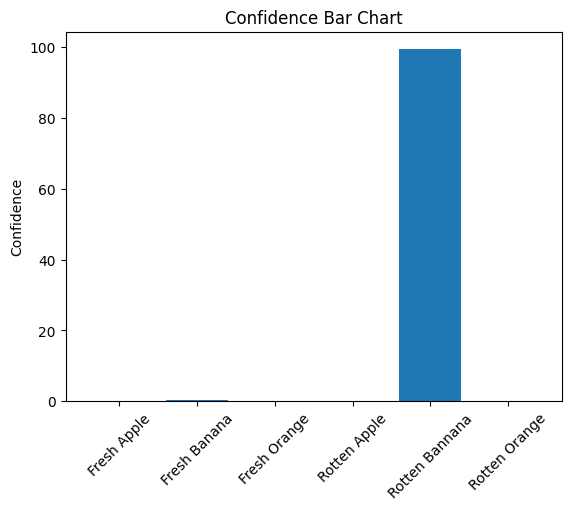

In [ ]:
img = cv2.imread("/content/cliked_banana.jpg")
img = prepare_img(img)
check_img(model2, img)

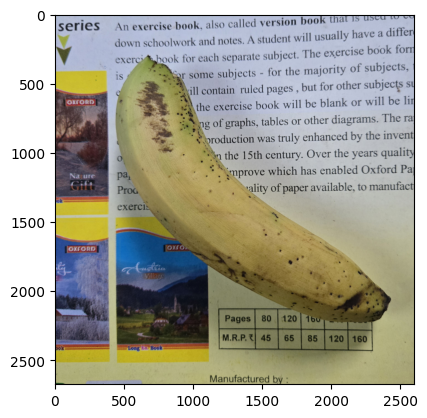

In [ ]:
#a partially rotten cliked_banana.jpg
img = plt.imread('/content/cliked_banana2.jpg')
plt.imshow(img)

Fresh Banana with confidence of 90.93520641326904%



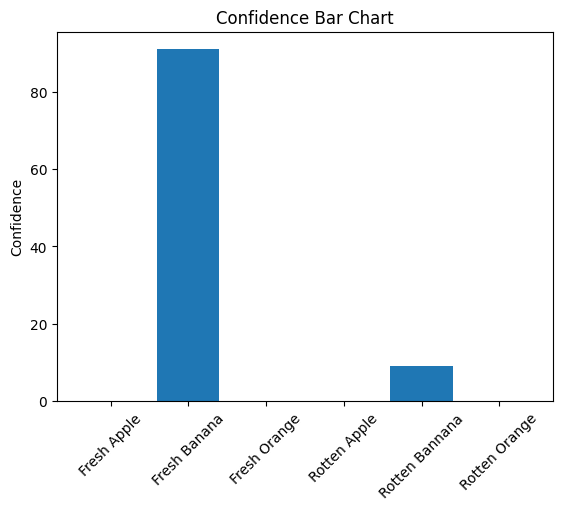

In [ ]:
#cliked_banana-with-noisy-background.jpg
img = cv2.imread('/content/cliked_banana2.jpg')
img = prepare_img(img)
check_img(model1, img)

Rotten Bannana with confidence of 98.95074963569641%



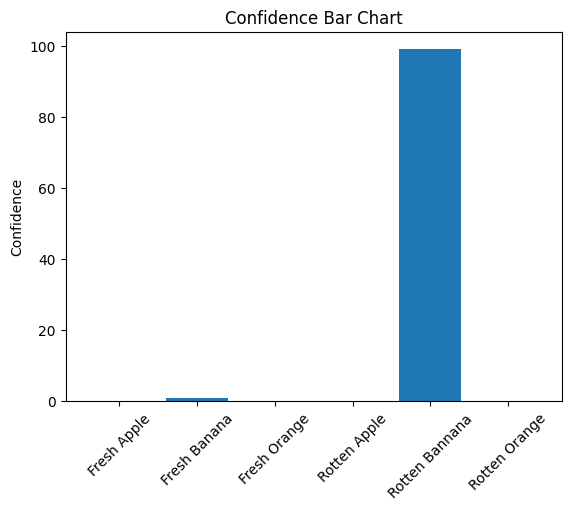

In [ ]:
img = cv2.imread("/content/cliked_banana2.jpg")
img = prepare_img(img)
check_img(model2, img)